In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
from matplotlib.patches import Rectangle
import seaborn as sns

import anndata as ad

from sklearn.metrics.pairwise import pairwise_distances
import scipy.stats as ss

from pprint import pprint

In [2]:
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=300, frameon=True, vector_friendly=True, fontsize=8, figsize=(8, 4),
                     color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')

sc.settings.figdir = "codexRNASeqIntegration/"

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

In [3]:
PATH_TO_CODEX = "GatedPatientData/ALL_Annotated.feather"
PATH_TO_SEQ = "scRNA-seq/Redone22/Manuscript/CD45/Data/annotated_CD45.h5ad"
PATH_TO_MAPPER = "Protein-Gene-Map-CD45.csv"

patient_lst = ["LHCC35", "LHCC44", "LHCC45", "LHCC46",
               "LHCC47", "LHCC48", "LHCC54", "Pat52"]

In [4]:
codex = pd.read_feather(PATH_TO_CODEX)
pgmapper = pd.read_csv(PATH_TO_MAPPER, header=0, sep=";")
pgmapper.dropna(inplace=True)
seq = sc.read_h5ad(PATH_TO_SEQ)

In [5]:
seq.var.highly_variable.sum()

1140

In [6]:
codex = codex[codex["CD45 Positive Classification"] == 1]
codex = codex[~codex.Class.isin(
    ["Junk", "Mixed immune positive", "Granulocytes/PMN MDSC 1", "Granulocytes/PMN MDSC 2"])]


patient_lst = seq.obs.Patient.unique().to_list()

codex = codex[codex.Patient.isin(patient_lst)].copy()

class_mapper = {a: a for a in codex.Class.unique()}
class_mapper["B cell 1"] = "B cell"
class_mapper["B cell 2"] = "B cell"
class_mapper["B cell 3"] = "B cell"
class_mapper["NK cells 1"] = "NK cell"
class_mapper["NK cells 2"] = "NK cell"
class_mapper["M2 macrophage 1"] = "TAM PD-L1-"
class_mapper["M2 macrophage 2"] = "TAM PD-L1+"
codex.Class = codex.Class.map(class_mapper)

pgmapper.Antigen = pgmapper.Antigen.str.strip()
pgmapper.Gene = pgmapper.Gene.str.replace(" ", "")
pgmapper.Gene = pgmapper.Gene.str.split(",")
pgmapper = pgmapper.explode("Gene")
pgmapper.reset_index(drop=True, inplace=True)

column_mapper = {e: e.split(
    " ")[0]+"_codex" for e in codex.columns if "Intensity" in e}
markers = list(column_mapper.values())

codex = codex.rename(mapper=column_mapper, axis=1)

codex_imputed = codex.copy()

for _, b in pgmapper.iterrows():
    codex_imputed[b["Gene"]] = codex_imputed[b["Antigen"]+"_codex"].copy()

codex_imputed.drop(markers, inplace=True, axis=1)

gene_comparison = list(set(codex_imputed.columns.to_list()
                           ).intersection(seq.var_names.to_list()))

adata_codex = ad.AnnData(codex_imputed[gene_comparison])
adata_codex.obs_names = [f"Cell_{i:d}" for i in range(adata_codex.n_obs)]
adata_codex.var_names = gene_comparison
adata_codex.obs["Celltype"] = codex_imputed["Celltype"].values.copy()
adata_codex.obs["Annotation_coarse"] = codex_imputed["Class"].values.copy()
adata_codex.obs["Patient"] = codex_imputed["Patient"].values.copy()
adata_codex.obs["Tissue"] = codex_imputed["Tissue"].values.copy()


seq = seq[:, gene_comparison].copy()

adata_codex.obs["Annotation_coarse"] = adata_codex.obs["Annotation_coarse"].astype("category")

mean_seq = pd.DataFrame(columns=seq.var_names, index=seq.obs["leiden_r1.0"].cat.categories)
mean_codex = pd.DataFrame(columns=seq.var_names, index=adata_codex.obs['Annotation_coarse'].cat.categories)

for clust in seq.obs["leiden_r1.0"].cat.categories:
    mean_seq.loc[clust] = seq[seq.obs["leiden_r1.0"].isin([clust]), :].X.mean(0)

for clust in adata_codex.obs["Annotation_coarse"].cat.categories:
    mean_codex.loc[clust] = adata_codex[adata_codex.obs['Annotation_coarse'].isin([clust]), :].X.mean(0)

dist_x_corr = pairwise_distances(X=mean_seq, Y=mean_codex, metric="correlation")

argmin_0 = dist_x_corr.argmin(axis=0)
argmin_1 = dist_x_corr.argmin(axis=1)

min_0 = dist_x_corr.min(axis=0)
min_1 = dist_x_corr.min(axis=1)

/var/folders/bj/fj47mx516_gc9y60blmf_5yr0000gn/T/ipykernel_90564/1311082314.py:42: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_codex = ad.AnnData(codex_imputed[gene_comparison])
/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
dist_df = pd.DataFrame(data=dist_x_corr, index=mean_seq.index, columns=mean_codex.index)
# Convert from distance back to correlation
dist_df = -dist_df + 1
print(dist_df.head(5))

                 B cell  CD4 T cells Naïve 1  Dendritic cells  Kupffer cells  \
c1_CD4 - IL7R  0.014730             0.487368        -0.385830      -0.328716   
c2_NK - CD16  -0.343795            -0.490817        -0.185753      -0.009101   
c3_NK - CD56  -0.186057            -0.519545        -0.282104      -0.180289   
c4_CD8 - GZMK  0.111660             0.276549        -0.290585      -0.216429   
c5_CD8 - LAG3  0.211028             0.267240        -0.105497      -0.179037   

                  MAITs   NK cell  T cells CD4+ 1  T cells CD4+PD-L1+  \
c1_CD4 - IL7R  0.379906 -0.217223        0.556796            0.693809   
c2_NK - CD16  -0.397616  0.300857       -0.406638           -0.363916   
c3_NK - CD56  -0.387920  0.295369       -0.438821           -0.375289   
c4_CD8 - GZMK  0.592222 -0.204682        0.239643            0.356075   
c5_CD8 - LAG3  0.394274 -0.330441        0.243230            0.298530   

               T cells CD57+  T cells CD8+PD-1high  T cells CD8+PD-1low  \
c1_CD

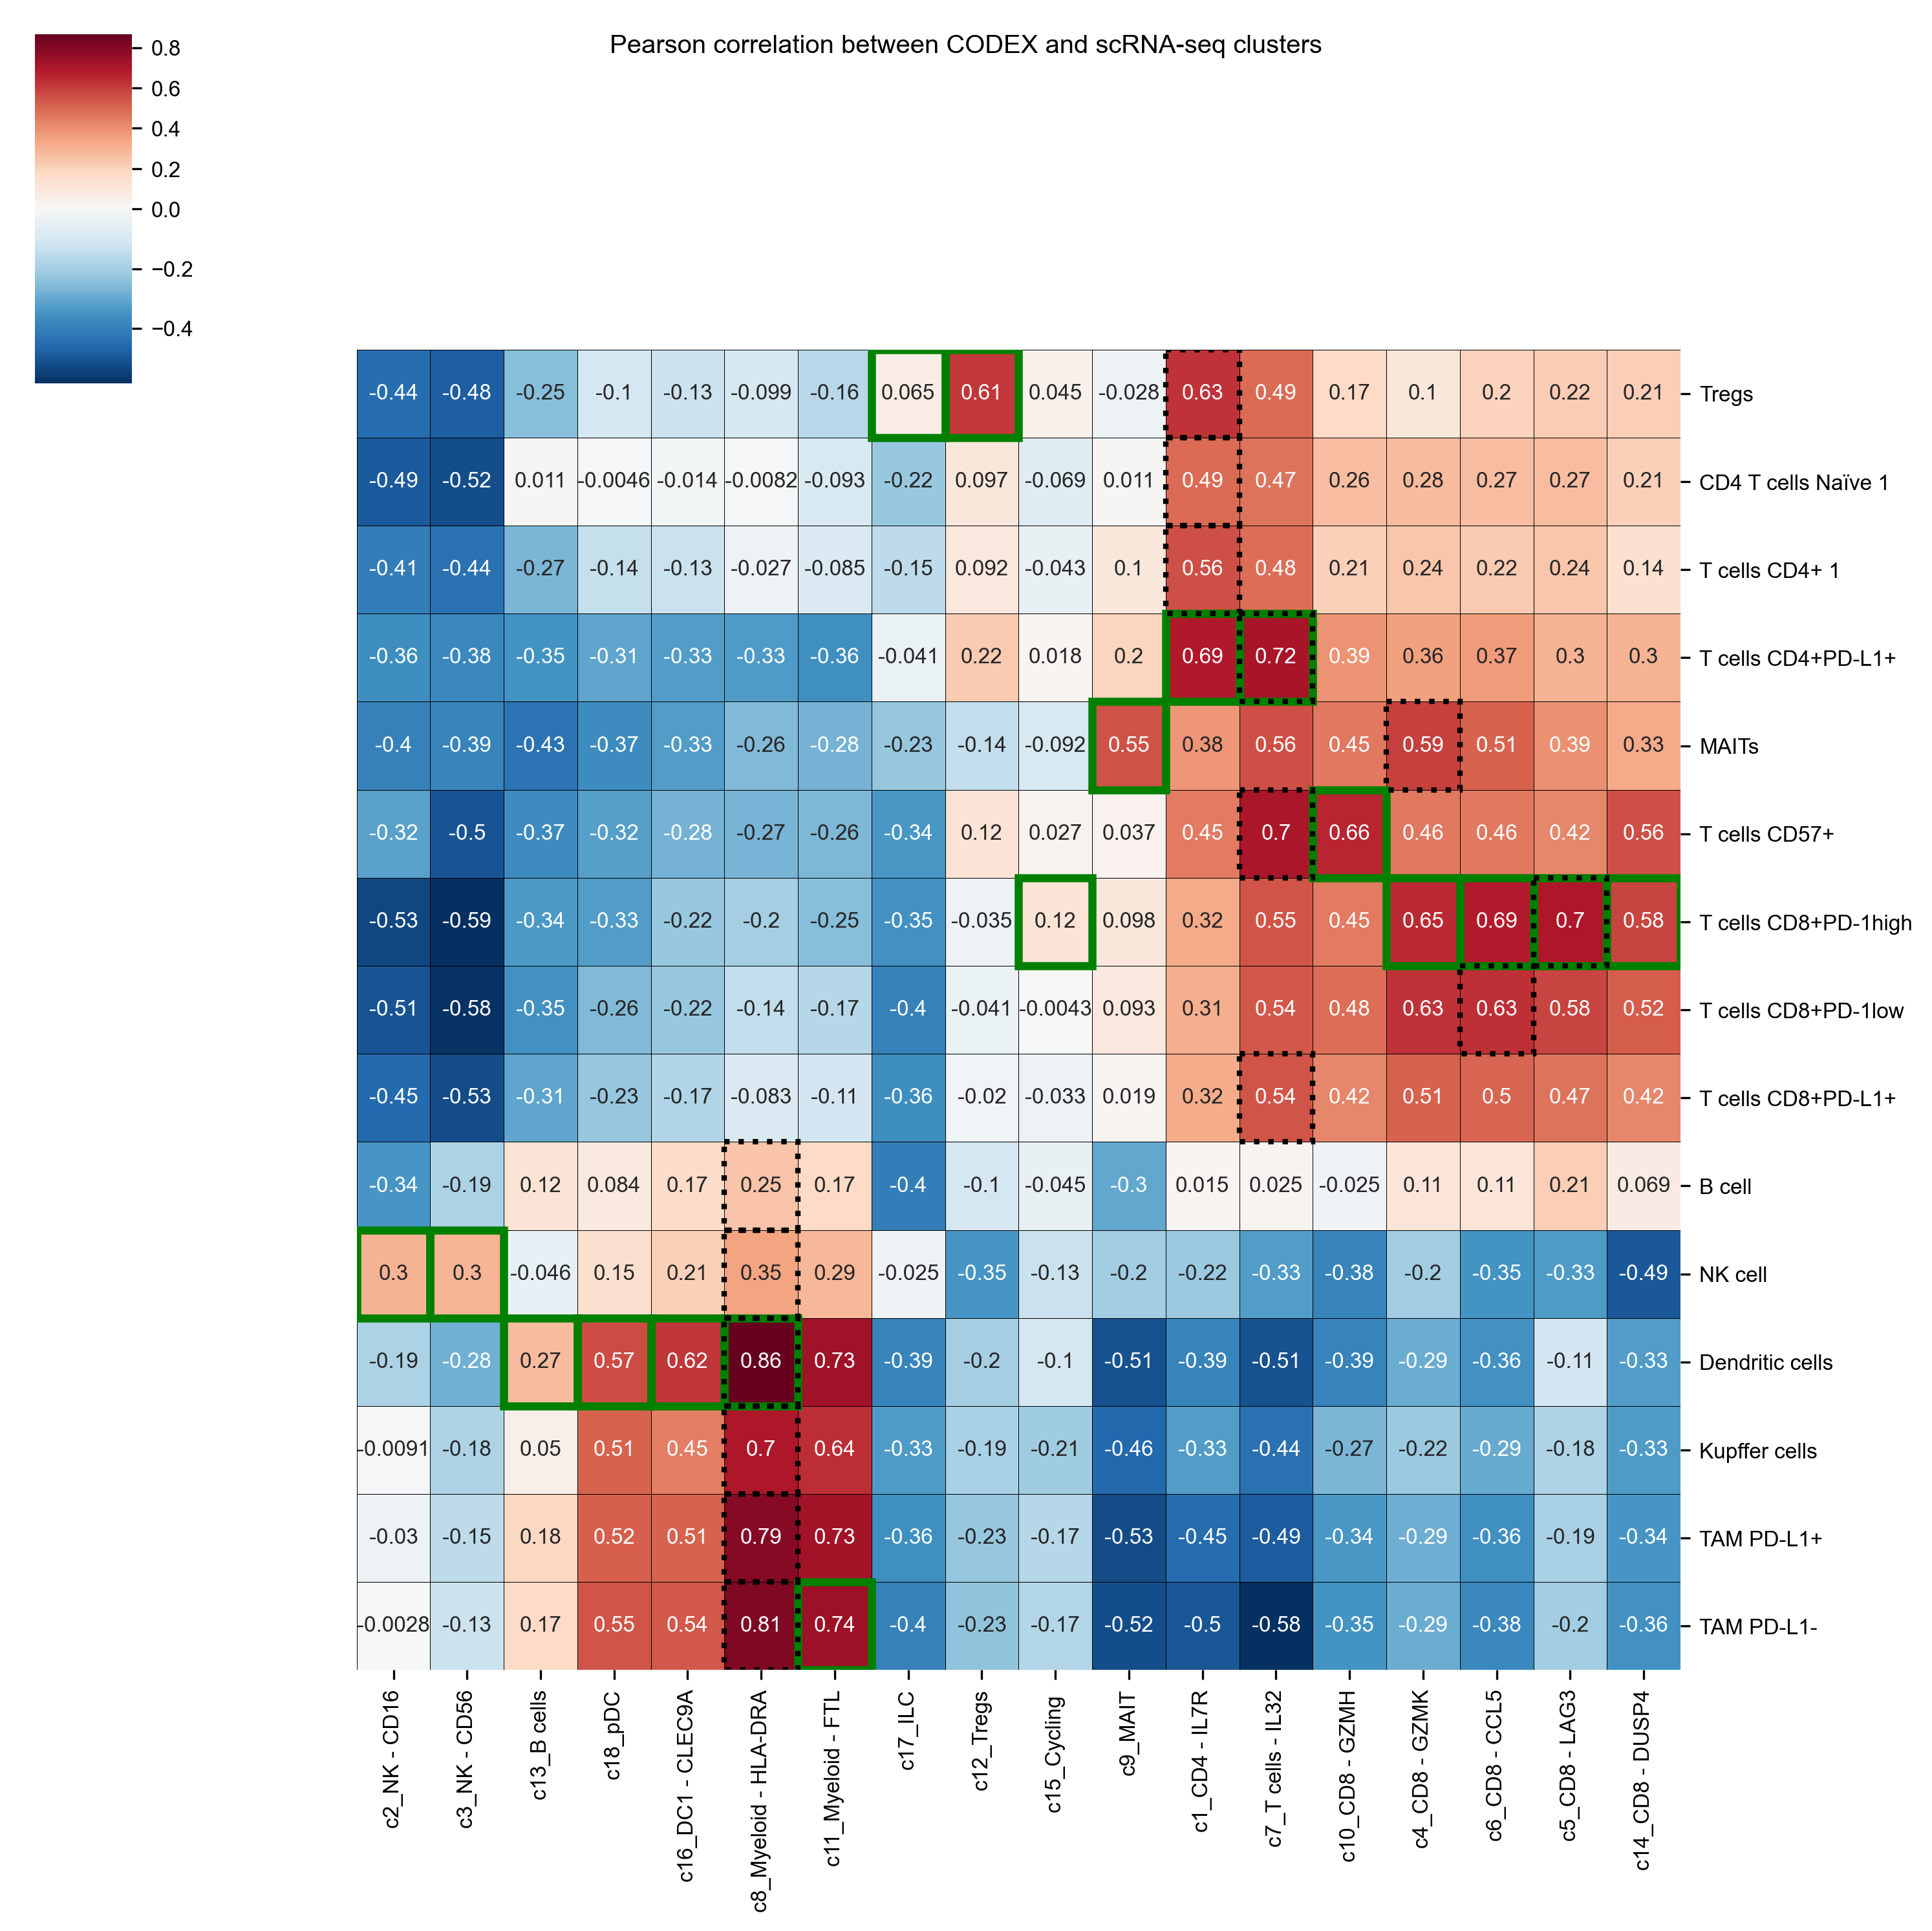

In [8]:
divnorm = colors.TwoSlopeNorm(vmin=dist_df.min().min(), vcenter=0, vmax=dist_df.max().max())
g = sns.clustermap(dist_df.T, cmap="RdBu_r", norm=divnorm, metric="correlation", annot=True, linewidths=0.2, linecolor="black",tree_kws={"linewidths": 0.})
row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind
patch_df = dist_df.T.copy()
patch_df = patch_df.iloc[row_order, col_order].copy()
ax = g.ax_heatmap

column_max = patch_df.idxmax(axis=0)
for col, variable in enumerate(patch_df.columns):
    position = patch_df.index.get_loc(column_max[variable])
    ax.add_patch(Rectangle((col, position),1,1, fill=False, edgecolor="green", lw=3,alpha=1))
    

row_max = patch_df.idxmax(axis=1)
for row, index in enumerate(patch_df.index):
    position = patch_df.columns.get_loc(row_max[index])
    ax.add_patch(Rectangle((position, row),1,1, fill=False, edgecolor="black", lw=2, linestyle="dotted"))
    
plt.suptitle(r"Pearson correlation between CODEX and scRNA-seq clusters")
plt.savefig("scRNA-seq/Redone22/Manuscript/Integration/AggregatedIntegration_Heatmap.pdf", dpi=400, transparent=True)
plt.show()